# import lib and function

In [1]:
import kagglehub
import pandas as pd
import os
import numpy as np
from pathlib import Path
from pyspark.sql import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_importance
import shap
from Utils.path_file_loader import target_path
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import optuna


sns.set(style="white")


c:\Users\korph\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

In [2]:
df = pd.read_csv(target_path("DataBase\Cleaned_data.csv"), encoding="utf-8")
df = df.drop(columns=['customerID'])
df = df.rename(columns={'Churn': 'label'})
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,label
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Declare Variable

In [3]:
categorical_feature_list = ["gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]

numerical_feature_list = [
    'SeniorCitizen', 
    'tenure', 
    'MonthlyCharges',
    'TotalCharges', 
]

# Module Function

In [4]:
def model_input_preparation(
    df: pd.DataFrame,
    categorical_feature_list: list,
    numerical_feature_list: list,
    one_hot: bool,
    scaler: bool,
    test_size: float,
    seed: int
):
    if one_hot:
        encoder = OneHotEncoder(sparse_output=False, drop=None)
        encoded = encoder.fit_transform(df[categorical_feature_list])
        df_encoded = pd.DataFrame(
            encoded,
            columns=encoder.get_feature_names_out(categorical_feature_list),
            index=df.index
        )
        df_final = pd.concat([df.drop(categorical_feature_list, axis=1), df_encoded], axis=1)
    else:
        df_final = df.copy()

    df_final["label"] = df_final["label"].map({"Yes": 1, "No": 0})

    X = df_final.drop(columns=['label'])
    y = df_final["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

    if scaler:
        std_scaler = StandardScaler()
        X_train_num = std_scaler.fit_transform(X_train[numerical_feature_list])
        X_test_num = std_scaler.transform(X_test[numerical_feature_list])

        X_train.loc[:, numerical_feature_list] = X_train_num
        X_test.loc[:, numerical_feature_list] = X_test_num

    return X_train, y_train, X_test, y_test


In [18]:
def model_automating_Hyperparamrter(trial, x_train, y_train, x_test, y_test):

    for col in x_train.select_dtypes(include="object").columns:
        x_train[col] = x_train[col].astype("category")
        x_test[col] = x_test[col].astype("category")

    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)

    model = xgb.XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        enable_categorical=True
    )
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    accuracy = accuracy_score(y_test, preds)
    return accuracy


# Script

## Linear Baseline

### One-hot + No scaler

In [6]:
X_train, y_train, X_test, y_test = model_input_preparation(df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot = True,
    scaler = False,
    test_size = 0.2,
    seed = 42
)
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8042243521476748, test set 0.8218594748048261


c:\Users\korph\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
X_train.head(5)

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2142,0,21,64.85,1336.80,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1623,0,54,97.20,5129.45,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
6074,0,1,23.45,23.45,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1362,0,4,70.20,237.95,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6754,0,0,61.90,0.00,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


### One-hot + scaler

In [8]:
X_train, y_train, X_test, y_test = model_input_preparation(df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot = True,
    scaler = True,
    test_size = 0.2,
    seed = 42
)

C:\Users\korph\AppData\Local\Temp\ipykernel_26800\2034999928.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.4377492  -0.4377492  -0.4377492  ... -0.4377492   2.28441306
 -0.4377492 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
C:\Users\korph\AppData\Local\Temp\ipykernel_26800\2034999928.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.46568336  0.88553679 -1.28460467 ... -0.83419795 -0.83419795
 -0.26095304]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numerical_feature_list] = X_train_num
C:\Users\korph\AppData\Local\Temp\ipykernel_26800\2034999928.py:34: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value

In [9]:
X_train.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
2142,-0.437749,-0.465683,-0.000474,-0.419925,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1623,-0.437749,0.885537,1.074754,1.256017,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
6074,-0.437749,-1.284605,-1.376499,-1.000283,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1362,-0.437749,-1.161766,0.177346,-0.905497,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6754,-0.437749,-1.325551,-0.098524,-1.010646,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [10]:
model = LogisticRegression(random_state=42).fit(X_train, y_train)
print(f"Logistic regression: training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

Logistic regression: training set acc: 0.8033368832090877, test set 0.8218594748048261


## XGBoost

In [11]:
X_train, y_train, X_test, y_test = model_input_preparation(df,
    categorical_feature_list,
    numerical_feature_list,
    one_hot = False,
    scaler = False,
    test_size = 0.2,
    seed = 42
)

In [16]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
2142,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.80
1623,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45
6074,Male,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45
1362,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95
6754,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,0.00


In [17]:
y_train.head()

2142    0
1623    0
6074    1
1362    1
6754    0
Name: label, dtype: int64

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: model_automating_Hyperparamrter(trial, X_train, y_train, X_test, y_test), n_trials=500)

print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-09-23 23:47:56,251] A new study created in memory with name: no-name-757c7879-4e5f-4ac1-8448-991bfc6d9f1a
c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:47:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-23 23:47:56,547] Trial 0 finished with value: 0.7821149751596878 and parameters: {'n_estimators': 265, 'max_depth': 7, 'learning_rate': 0.08263149024823459}. Best is trial 0 with value: 0.7821149751596878.
c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:47:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-09-23 23:47:57,709] Trial 1 finished with value: 0.7799858055358411 and parameters: {'n_estimators': 277, 'max_depth': 30, 'learning_rate': 0.04594

Best parameters: {'n_estimators': 289, 'max_depth': 4, 'learning_rate': 0.013536000803606557}
Best accuracy: 0.8168914123491838


In [22]:
model = xgb.XGBClassifier(
        n_estimators=289,
        max_depth=4,
        learning_rate=0.013536000803606557,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss',
        enable_categorical=True
    )
model.fit(X_train, y_train)
print(f"XGBoost : training set acc: {model.score(X_train, y_train)}, test set {model.score(X_test, y_test)}")

c:\Users\korph\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:54:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost : training set acc: 0.8159389421370252, test set 0.8168914123491838


### feature importance

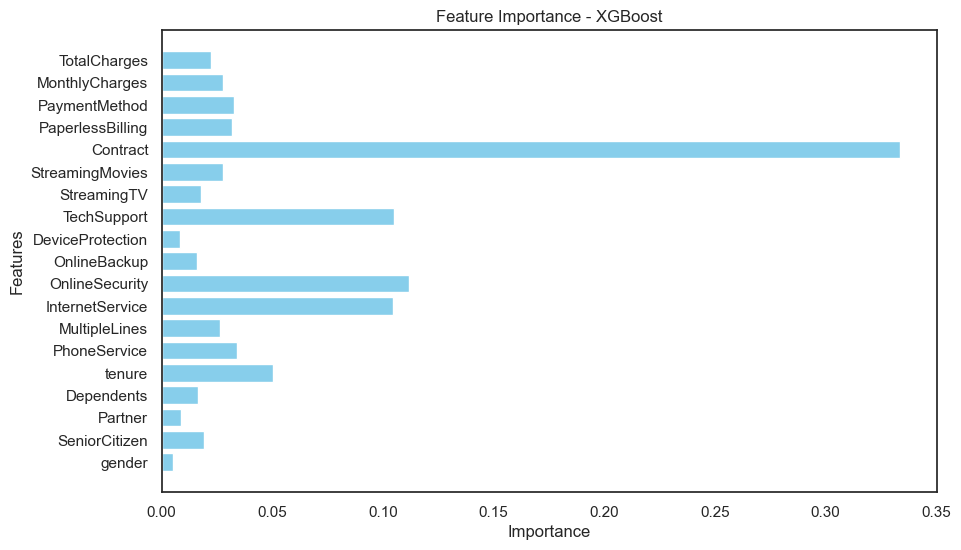

In [23]:
importance = model.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, importance, color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost")
plt.show()


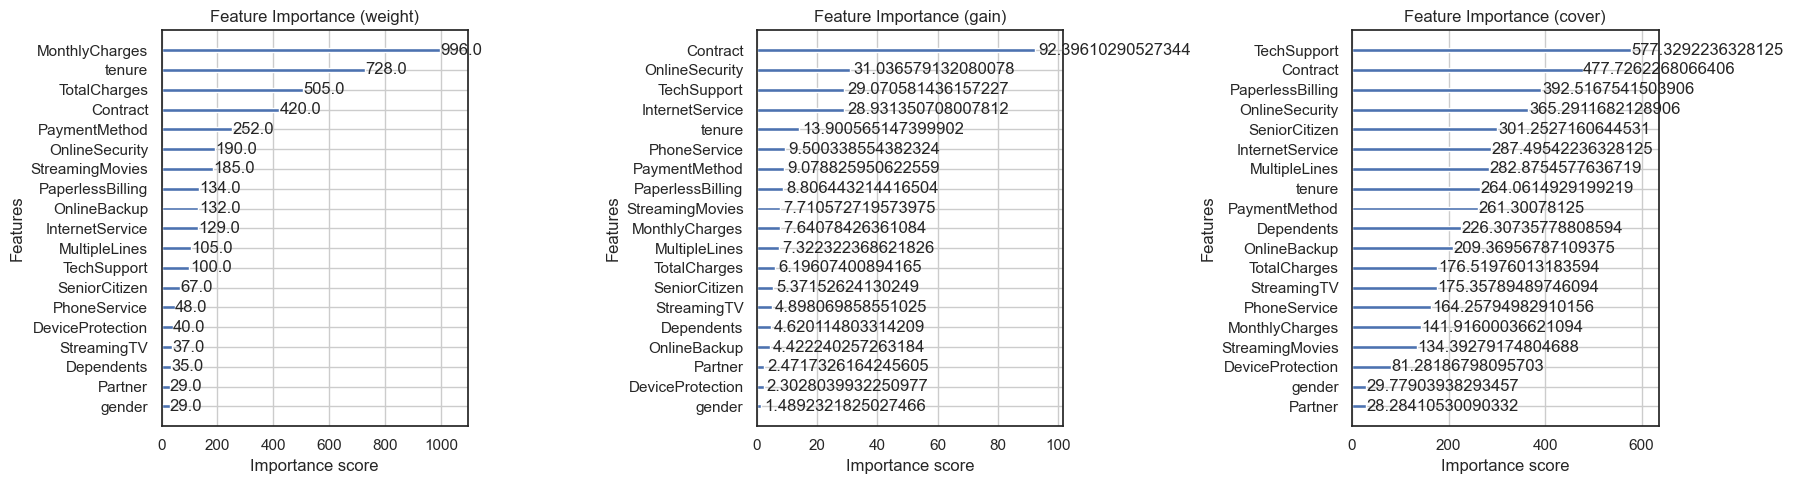

In [24]:
importance_types = ['weight', 'gain', 'cover']

plt.figure(figsize=(18, 5))

for i, imp_type in enumerate(importance_types, 1):
    plt.subplot(1, 3, i)
    plot_importance(model, importance_type=imp_type, ax=plt.gca(), title=f"Feature Importance ({imp_type})")
    
plt.tight_layout()
plt.show()

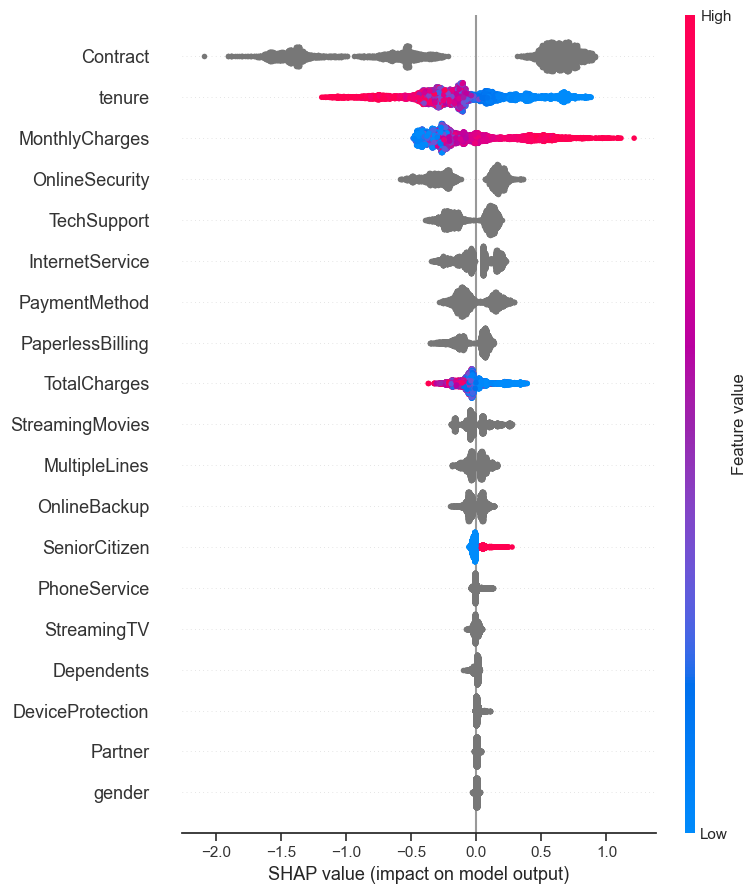

In [25]:
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)
